In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
df_product = pd.read_csv('../datasets/fashion/product_details.csv', sep=';')
df_product = df_product.loc[:, ~df_product.columns.str.contains('^Unnamed')]
df_product

,product_id,ratings,price,category,brand,kind
0,0,3.270463,53.916667,Dress,Adidas,Kids' Fashion
1,1,2.879264,44.500000,Dress,Adidas,Men's Fashion
2,2,2.673620,47.666667,Dress,Adidas,Women's Fashion
3,3,3.689981,50.200000,Dress,Gucci,Kids' Fashion
4,4,3.282323,51.125000,Dress,Gucci,Men's Fashion
...,...,...,...,...,...,...
70,70,2.436425,56.500000,T-shirt,Nike,Men's Fashion
71,71,2.636504,72.166667,T-shirt,Nike,Women's Fashion
72,72,3.548573,65.750000,T-shirt,Zara,Kids' Fashion
73,73,2.520955,52.818182,T-shirt,Zara,Men's Fashion


In [3]:
df_history = pd.read_csv('../datasets/fashion/purchase_history.csv', sep=';')
df_history = df_history.loc[:, ~df_history.columns.str.contains('^Unnamed')]
df_history['customer_id'] -= 1
df_history

,customer_id,product_id,purchase_date
0,18,1,NaN
1,96,38,NaN
2,24,2,NaN
3,56,43,NaN
4,78,61,NaN
...,...,...,...
995,19,44,NaN
996,41,54,NaN
997,8,58,NaN
998,7,74,NaN


In [4]:
df_dataset = df_history[['customer_id', 'product_id']]
df_dataset

,customer_id,product_id
0,18,1
1,96,38
2,24,2
3,56,43
4,78,61
...,...,...
995,19,44
996,41,54
997,8,58
998,7,74


In [5]:
df_freq = df_dataset.reset_index(names=['count']).groupby(by=['customer_id', 'product_id']).agg({'count': 'count'}).reset_index().sort_values(by=['count'], ascending=False)
df_freq

,customer_id,product_id,count
527,54,70,2
295,32,28,2
919,97,11,2
456,47,62,2
734,76,67,2
...,...,...,...
329,34,66,1
330,35,0,1
331,35,1,1
332,35,17,1


In [6]:
df_freq['count'].value_counts()

count
1    902
2     49
Name: count, dtype: int64

In [7]:
# sorted(df_dataset['customer_id'].unique())
# sorted(df_dataset['product_id'].unique())

In [8]:
total_user = len(df_dataset['customer_id'].unique())
total_product = len(df_dataset['product_id'].unique())
print(f'total_user: {total_user}')
print(f'total_product: {total_product}')

total_user: 100
total_product: 75


In [9]:
datatsets = np.zeros((total_user, total_product))
(datatsets.shape)

(100, 75)

In [10]:
for i, row in df_freq.iterrows():
    count = row['count']
    datatsets[row['customer_id'], row['product_id']] = 1

In [12]:
datatsets.sum(axis=1)

array([ 9.,  9., 10., 12.,  8., 13., 11., 10., 14., 11., 14.,  6., 10.,
        5.,  6.,  7.,  7.,  9.,  9.,  9.,  6.,  9.,  4., 11., 13., 10.,
       10.,  6.,  5., 11.,  9., 10., 10., 15., 12.,  9., 16., 13., 13.,
       10.,  9., 10.,  6., 11.,  5., 13.,  2., 12., 10., 11., 10., 12.,
        5., 13.,  8., 11.,  7.,  5.,  8., 12., 14.,  7., 10.,  9., 13.,
        9.,  7.,  9.,  7.,  8., 12., 10., 13.,  9.,  8.,  8., 13.,  9.,
       10., 15.,  6., 11.,  8., 11.,  4.,  3., 11.,  9., 13.,  8., 10.,
       13.,  7.,  9.,  9.,  6.,  8., 13.,  8., 13.])

In [13]:
# Drop 
min_items = 12 # datatsets.sum(axis=1).mean()

datatsets_train = datatsets[datatsets.sum(axis=1) <= min_items, :]
datatsets_test = datatsets[datatsets.sum(axis=1) > min_items, :]

print(f'datatsets_train: {datatsets_train.shape}')
print(f'datatsets_test: {datatsets_test.shape}')

datatsets_train: (81, 75)
datatsets_test: (19, 75)


In [65]:
import itertools

def generate_trainset(datatsets):
    x, y, z = [], [], []
    for row in datatsets:
        product_ids = np.argwhere(row == 1).reshape(-1).tolist()
        for c in range(1, min(4, len(product_ids) - 2)):
            combs = list(itertools.combinations(product_ids, c))
            
            for k, comb in enumerate(combs):
                combinations = np.zeros((1, total_product))

                for i, product_id in enumerate(comb):
                    combinations[0, product_id] = 1
                y.append(row - combinations[0])
                z.append(row)
                x.extend(combinations)
            
    return np.array(x), np.array(y), np.array(z)

x_train, y_train, z_train = generate_trainset(datatsets_train)
x_test, y_test, z_test = generate_trainset(datatsets_test)

print(f'Train: {(x_train.shape), (y_train.shape)}')
print(f'Test: {(x_test.shape), (y_test.shape)}')

Train: ((10647, 75), (10647, 75))
Test: ((8154, 75), (8154, 75))


# Model

In [103]:
class Autoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim * 2, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
            layers.Dense(latent_dim // 2, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(latent_dim, activation='relu'),
            layers.Dense(latent_dim * 2, activation='relu'),
            layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
def build_model(model_name='autoencoder'):
    shape = x_train.shape[1:]
    latent_dim = 32
    if model_name == 'autoencoder':
        model = Autoencoder(latent_dim, shape)
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), 
            loss=losses.MeanSquaredError(), 
            metrics=tf.keras.metrics.BinaryAccuracy(),
        )

    else:
        model = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(x_train.shape[1] * 4, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(x_train.shape[1] * 4, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(x_train.shape[1] * 2, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(x_train.shape[1], activation='sigmoid'),    
        ])
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), 
            loss=losses.MeanSquaredError(), 
            metrics=tf.keras.metrics.BinaryAccuracy(),
        )
    return model

In [104]:
# model_name = 'NN'
model_name = 'autoencoder'
model = build_model(model_name)

In [105]:
callback_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=0.001,
    cooldown=0,
    min_lr=0,
)
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{model_name}/checkpoint/',
    monitor='val_loss',
    save_best_only=True,
    save_freq='epoch',
)

In [106]:
res = model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=2048,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[callback_plateau, callback_checkpoint], 
)

Epoch 1/200
1/6 [====>.........................] - ETA: 1s - loss: 0.2497 - binary_accuracy: 0.5290INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 1s 83ms/step - loss: 0.2495 - binary_accuracy: 0.5383 - val_loss: 0.2494 - val_binary_accuracy: 0.5405 - lr: 1.0000e-04
Epoch 2/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2492 - binary_accuracy: 0.5550INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 72ms/step - loss: 0.2491 - binary_accuracy: 0.5638 - val_loss: 0.2490 - val_binary_accuracy: 0.5609 - lr: 1.0000e-04
Epoch 3/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2488 - binary_accuracy: 0.5804WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 1s 159ms/step - loss: 0.2486 - binary_accuracy: 0.5880 - val_loss: 0.2486 - val_binary_accuracy: 0.5802 - lr: 1.0000e-04
Epoch 4/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2483 - binary_accuracy: 0.6018INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 66ms/step - loss: 0.2481 - binary_accuracy: 0.6091 - val_loss: 0.2481 - val_binary_accuracy: 0.5978 - lr: 1.0000e-04
Epoch 5/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2478 - binary_accuracy: 0.6219INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 66ms/step - loss: 0.2476 - binary_accuracy: 0.6286 - val_loss: 0.2476 - val_binary_accuracy: 0.6135 - lr: 1.0000e-04
Epoch 6/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2472 - binary_accuracy: 0.6406INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 63ms/step - loss: 0.2470 - binary_accuracy: 0.6460 - val_loss: 0.2470 - val_binary_accuracy: 0.6277 - lr: 1.0000e-04
Epoch 7/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2466 - binary_accuracy: 0.6569INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 63ms/step - loss: 0.2463 - binary_accuracy: 0.6616 - val_loss: 0.2464 - val_binary_accuracy: 0.6407 - lr: 1.0000e-04
Epoch 8/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2458 - binary_accuracy: 0.6716INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 64ms/step - loss: 0.2456 - binary_accuracy: 0.6760 - val_loss: 0.2456 - val_binary_accuracy: 0.6527 - lr: 1.0000e-04
Epoch 9/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2450 - binary_accuracy: 0.6835INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 64ms/step - loss: 0.2447 - binary_accuracy: 0.6891 - val_loss: 0.2448 - val_binary_accuracy: 0.6643 - lr: 1.0000e-04
Epoch 10/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2441 - binary_accuracy: 0.6971INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 62ms/step - loss: 0.2437 - binary_accuracy: 0.7020 - val_loss: 0.2438 - val_binary_accuracy: 0.6755 - lr: 1.0000e-04
Epoch 11/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2430 - binary_accuracy: 0.7108INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 64ms/step - loss: 0.2426 - binary_accuracy: 0.7146 - val_loss: 0.2427 - val_binary_accuracy: 0.6866 - lr: 1.0000e-04
Epoch 12/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2419 - binary_accuracy: 0.7217INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 1s 106ms/step - loss: 0.2413 - binary_accuracy: 0.7265 - val_loss: 0.2414 - val_binary_accuracy: 0.6977 - lr: 1.0000e-04
Epoch 13/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2404 - binary_accuracy: 0.7339INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 64ms/step - loss: 0.2398 - binary_accuracy: 0.7386 - val_loss: 0.2399 - val_binary_accuracy: 0.7084 - lr: 1.0000e-04
Epoch 14/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2387 - binary_accuracy: 0.7470INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 63ms/step - loss: 0.2381 - binary_accuracy: 0.7502 - val_loss: 0.2382 - val_binary_accuracy: 0.7189 - lr: 1.0000e-04
Epoch 15/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2370 - binary_accuracy: 0.7579INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 64ms/step - loss: 0.2361 - binary_accuracy: 0.7616 - val_loss: 0.2362 - val_binary_accuracy: 0.7287 - lr: 1.0000e-04
Epoch 16/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2347 - binary_accuracy: 0.7691INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 67ms/step - loss: 0.2338 - binary_accuracy: 0.7728 - val_loss: 0.2339 - val_binary_accuracy: 0.7379 - lr: 1.0000e-04
Epoch 17/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2322 - binary_accuracy: 0.7796INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 77ms/step - loss: 0.2312 - binary_accuracy: 0.7835 - val_loss: 0.2314 - val_binary_accuracy: 0.7465 - lr: 1.0000e-04
Epoch 18/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2294 - binary_accuracy: 0.7897INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 73ms/step - loss: 0.2282 - binary_accuracy: 0.7945 - val_loss: 0.2285 - val_binary_accuracy: 0.7554 - lr: 1.0000e-04
Epoch 19/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2261 - binary_accuracy: 0.8020INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 69ms/step - loss: 0.2248 - binary_accuracy: 0.8059 - val_loss: 0.2252 - val_binary_accuracy: 0.7641 - lr: 1.0000e-04
Epoch 20/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2223 - binary_accuracy: 0.8143INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 1s 111ms/step - loss: 0.2210 - binary_accuracy: 0.8167 - val_loss: 0.2216 - val_binary_accuracy: 0.7729 - lr: 1.0000e-04
Epoch 21/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2186 - binary_accuracy: 0.8226INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 72ms/step - loss: 0.2167 - binary_accuracy: 0.8268 - val_loss: 0.2175 - val_binary_accuracy: 0.7814 - lr: 1.0000e-04
Epoch 22/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2137 - binary_accuracy: 0.8332INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 72ms/step - loss: 0.2119 - binary_accuracy: 0.8360 - val_loss: 0.2130 - val_binary_accuracy: 0.7888 - lr: 1.0000e-04
Epoch 23/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2086 - binary_accuracy: 0.8413INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 75ms/step - loss: 0.2067 - binary_accuracy: 0.8434 - val_loss: 0.2082 - val_binary_accuracy: 0.7950 - lr: 1.0000e-04
Epoch 24/200
1/6 [====>.........................] - ETA: 0s - loss: 0.2027 - binary_accuracy: 0.8475INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 69ms/step - loss: 0.2009 - binary_accuracy: 0.8489 - val_loss: 0.2029 - val_binary_accuracy: 0.7997 - lr: 1.0000e-04
Epoch 25/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1969 - binary_accuracy: 0.8521INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 71ms/step - loss: 0.1946 - binary_accuracy: 0.8532 - val_loss: 0.1973 - val_binary_accuracy: 0.8038 - lr: 1.0000e-04
Epoch 26/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1905 - binary_accuracy: 0.8559INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 73ms/step - loss: 0.1878 - binary_accuracy: 0.8572 - val_loss: 0.1914 - val_binary_accuracy: 0.8080 - lr: 1.0000e-04
Epoch 27/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1836 - binary_accuracy: 0.8595INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 67ms/step - loss: 0.1807 - binary_accuracy: 0.8612 - val_loss: 0.1853 - val_binary_accuracy: 0.8128 - lr: 1.0000e-04
Epoch 28/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1761 - binary_accuracy: 0.8638INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 72ms/step - loss: 0.1732 - binary_accuracy: 0.8659 - val_loss: 0.1792 - val_binary_accuracy: 0.8177 - lr: 1.0000e-04
Epoch 29/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1680 - binary_accuracy: 0.8693INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 1s 107ms/step - loss: 0.1656 - binary_accuracy: 0.8707 - val_loss: 0.1730 - val_binary_accuracy: 0.8223 - lr: 1.0000e-04
Epoch 30/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1603 - binary_accuracy: 0.8748INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 66ms/step - loss: 0.1579 - binary_accuracy: 0.8761 - val_loss: 0.1671 - val_binary_accuracy: 0.8274 - lr: 1.0000e-04
Epoch 31/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1532 - binary_accuracy: 0.8797INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 66ms/step - loss: 0.1502 - binary_accuracy: 0.8820 - val_loss: 0.1613 - val_binary_accuracy: 0.8321 - lr: 1.0000e-04
Epoch 32/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1451 - binary_accuracy: 0.8855INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 65ms/step - loss: 0.1428 - binary_accuracy: 0.8865 - val_loss: 0.1560 - val_binary_accuracy: 0.8359 - lr: 1.0000e-04
Epoch 33/200
4/6 [===================>..........] - ETA: 0s - loss: 0.1363 - binary_accuracy: 0.8893INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 83ms/step - loss: 0.1357 - binary_accuracy: 0.8895 - val_loss: 0.1512 - val_binary_accuracy: 0.8394 - lr: 1.0000e-04
Epoch 34/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1310 - binary_accuracy: 0.8916INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 70ms/step - loss: 0.1291 - binary_accuracy: 0.8916 - val_loss: 0.1469 - val_binary_accuracy: 0.8412 - lr: 1.0000e-04
Epoch 35/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1255 - binary_accuracy: 0.8918INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 70ms/step - loss: 0.1230 - binary_accuracy: 0.8925 - val_loss: 0.1433 - val_binary_accuracy: 0.8420 - lr: 1.0000e-04
Epoch 36/200
4/6 [===================>..........] - ETA: 0s - loss: 0.1181 - binary_accuracy: 0.8933INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 90ms/step - loss: 0.1176 - binary_accuracy: 0.8935 - val_loss: 0.1402 - val_binary_accuracy: 0.8446 - lr: 1.0000e-04
Epoch 37/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1152 - binary_accuracy: 0.8942INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 81ms/step - loss: 0.1128 - binary_accuracy: 0.8961 - val_loss: 0.1377 - val_binary_accuracy: 0.8497 - lr: 1.0000e-04
Epoch 38/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1108 - binary_accuracy: 0.8979INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 1s 140ms/step - loss: 0.1087 - binary_accuracy: 0.9001 - val_loss: 0.1357 - val_binary_accuracy: 0.8531 - lr: 1.0000e-04
Epoch 39/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1064 - binary_accuracy: 0.9022INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 78ms/step - loss: 0.1052 - binary_accuracy: 0.9024 - val_loss: 0.1341 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 40/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1036 - binary_accuracy: 0.9022INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 87ms/step - loss: 0.1023 - binary_accuracy: 0.9027 - val_loss: 0.1329 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 41/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1008 - binary_accuracy: 0.9025INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 78ms/step - loss: 0.0999 - binary_accuracy: 0.9027 - val_loss: 0.1320 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 42/200
1/6 [====>.........................] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.9032INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 77ms/step - loss: 0.0978 - binary_accuracy: 0.9027 - val_loss: 0.1314 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 43/200
1/6 [====>.........................] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.9029INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 71ms/step - loss: 0.0962 - binary_accuracy: 0.9027 - val_loss: 0.1309 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 44/200
1/6 [====>.........................] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9022INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 67ms/step - loss: 0.0948 - binary_accuracy: 0.9027 - val_loss: 0.1306 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 45/200
4/6 [===================>..........] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9029INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 82ms/step - loss: 0.0937 - binary_accuracy: 0.9027 - val_loss: 0.1304 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 46/200
1/6 [====>.........................] - ETA: 0s - loss: 0.0928 - binary_accuracy: 0.9033INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 1s 121ms/step - loss: 0.0928 - binary_accuracy: 0.9027 - val_loss: 0.1302 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 47/200
1/6 [====>.........................] - ETA: 0s - loss: 0.0925 - binary_accuracy: 0.9024INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 71ms/step - loss: 0.0921 - binary_accuracy: 0.9027 - val_loss: 0.1302 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 48/200
1/6 [====>.........................] - ETA: 0s - loss: 0.0914 - binary_accuracy: 0.9031INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 72ms/step - loss: 0.0915 - binary_accuracy: 0.9027 - val_loss: 0.1301 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 49/200
1/6 [====>.........................] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9032INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/checkpoint/assets


6/6 [==============================] - 0s 69ms/step - loss: 0.0910 - binary_accuracy: 0.9027 - val_loss: 0.1301 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 50/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0906 - binary_accuracy: 0.9027 - val_loss: 0.1301 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 51/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0902 - binary_accuracy: 0.9027 - val_loss: 0.1301 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 52/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0899 - binary_accuracy: 0.9027 - val_loss: 0.1301 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 53/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0897 - binary_accuracy: 0.9027 - val_loss: 0.1302 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 54/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0895 - binary_accuracy: 0.9027 - val_loss: 0.1302 - val_binary_accuracy: 0.8537

In [109]:
model.save_weights(f'../models/{model_name}/latest/')
model.evaluate(x_test, y_test)

255/255 [==============================] - 0s 736us/step - loss: 0.1302 - binary_accuracy: 0.8537


[0.130248561501503, 0.8537061810493469]

In [110]:
model_best = build_model(model_name)
model_best.load_weights(f'../models/{model_name}/checkpoint/')
model_best.evaluate(x_test, y_test)

 91/255 [=========>....................] - ETA: 0s - loss: 0.1365 - binary_accuracy: 0.8449 

2024-01-27 15:12:45.183934: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ../models/autoencoder/checkpoint/: FAILED_PRECONDITION: ../models/autoencoder/checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


255/255 [==============================] - 0s 484us/step - loss: 0.1301 - binary_accuracy: 0.8537


[0.13010217249393463, 0.8537061810493469]

In [111]:
model_best.save(f'../models/{model_name}/model')

INFO:tensorflow:Assets written to: ../models/autoencoder/model/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/model/assets


# History

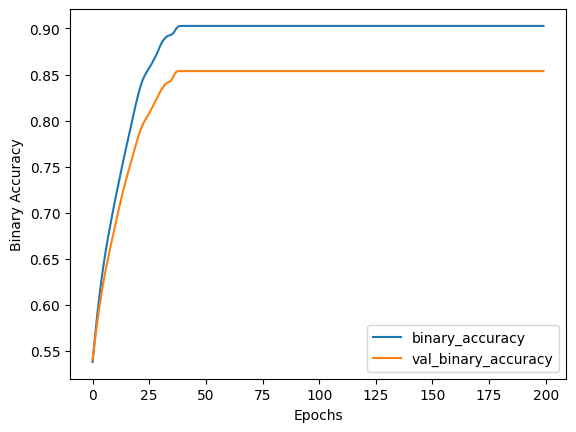

In [112]:
plt.plot(res.history['binary_accuracy'], label='binary_accuracy')
plt.plot(res.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.ylabel('Binary Accuracy')

plt.xlabel('Epochs')
plt.legend()
plt.show()

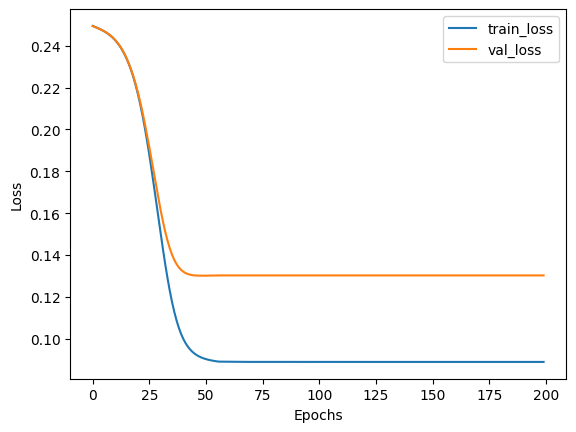

In [113]:
plt.plot(res.history['loss'], label='train_loss')
plt.plot(res.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict

In [114]:
df_product

,product_id,ratings,price,category,brand,kind
0,0,3.270463,53.916667,Dress,Adidas,Kids' Fashion
1,1,2.879264,44.500000,Dress,Adidas,Men's Fashion
2,2,2.673620,47.666667,Dress,Adidas,Women's Fashion
3,3,3.689981,50.200000,Dress,Gucci,Kids' Fashion
4,4,3.282323,51.125000,Dress,Gucci,Men's Fashion
...,...,...,...,...,...,...
70,70,2.436425,56.500000,T-shirt,Nike,Men's Fashion
71,71,2.636504,72.166667,T-shirt,Nike,Women's Fashion
72,72,3.548573,65.750000,T-shirt,Zara,Kids' Fashion
73,73,2.520955,52.818182,T-shirt,Zara,Men's Fashion


In [115]:
# Input: from dataset
idx = -432
input_arr = x_test[idx]
output_arr = y_test[idx]
products_on_chart = np.argwhere(input_arr > 0.5).reshape(-1).tolist()
products_truth = np.argwhere(output_arr > 0.5).reshape(-1).tolist()

# # Input: manual select
# # products_on_chart = [70, ]
# products_on_chart = [0, 1]
# products_truth = products_on_chart
# input_arr = np.zeros((1, total_product))
# input_arr[0, products_on_chart] = 1
# # for id in products_on_chart:
#     # input_arr[0, id] = 1

# Input From Customer
customer_id = 0
products_on_chart = df_dataset[df_dataset['customer_id'] == customer_id]['product_id'].unique().tolist()
products_truth = products_on_chart

print(f'products_on_chart: {products_on_chart}')
print(f'Items on your chart: ')
df_product.iloc[products_on_chart]

products_on_chart: [41, 65, 55, 9, 57, 69, 72, 11, 34]
Items on your chart: 


,product_id,ratings,price,category,brand,kind
41,41,2.681958,66.176471,Shoes,Nike,Women's Fashion
65,65,2.965708,60.545455,T-shirt,Gucci,Women's Fashion
55,55,2.953674,57.833333,Sweater,Nike,Men's Fashion
9,9,3.108999,60.117647,Dress,Nike,Kids' Fashion
57,57,3.299868,60.416667,Sweater,Zara,Kids' Fashion
69,69,3.171572,60.117647,T-shirt,Nike,Kids' Fashion
72,72,3.548573,65.750000,T-shirt,Zara,Kids' Fashion
11,11,3.510605,48.000000,Dress,Nike,Women's Fashion
34,34,3.281908,53.181818,Shoes,Gucci,Men's Fashion


In [116]:
print(f'Another Product you actualy buy:')
df_product_act = df_product.iloc[products_truth].copy()
df_product_act

Another Product you actualy buy:


,product_id,ratings,price,category,brand,kind
41,41,2.681958,66.176471,Shoes,Nike,Women's Fashion
65,65,2.965708,60.545455,T-shirt,Gucci,Women's Fashion
55,55,2.953674,57.833333,Sweater,Nike,Men's Fashion
9,9,3.108999,60.117647,Dress,Nike,Kids' Fashion
57,57,3.299868,60.416667,Sweater,Zara,Kids' Fashion
69,69,3.171572,60.117647,T-shirt,Nike,Kids' Fashion
72,72,3.548573,65.750000,T-shirt,Zara,Kids' Fashion
11,11,3.510605,48.000000,Dress,Nike,Women's Fashion
34,34,3.281908,53.181818,Shoes,Gucci,Men's Fashion


In [117]:
x = np.zeros((1, total_product))
x[0, products_on_chart] = 1
pred = model(x)

df_product_pred = df_product.copy()
df_product_pred['Score'] = pred.numpy()[0]
df_product_pred['Correct'] = df_product_pred['product_id'].isin(df_product_act['product_id'].tolist())
df_product_pred = df_product_pred[~df_product_pred['product_id'].isin(products_on_chart)]
df_product_pred = df_product_pred.sort_values(by=['Score'], ascending=False).head(10)

print(f'Another product you might like:')
print(df_product_pred.shape)
df_product_pred

Another product you might like:
(10, 8)


,product_id,ratings,price,category,brand,kind,Score,Correct
19,19,3.596602,54.153846,Jeans,Gucci,Men's Fashion,0.070356,False
44,44,2.333109,49.466667,Shoes,Zara,Women's Fashion,0.050090,False
32,32,2.723359,68.428571,Shoes,Adidas,Women's Fashion,0.039852,False
24,24,2.461879,56.650000,Jeans,Nike,Kids' Fashion,0.027449,False
61,61,2.784215,58.294118,T-shirt,Adidas,Men's Fashion,0.023923,False
21,21,2.813687,56.857143,Jeans,H&M,Kids' Fashion,0.019330,False
3,3,3.689981,50.200000,Dress,Gucci,Kids' Fashion,0.016861,False
39,39,3.122795,46.187500,Shoes,Nike,Kids' Fashion,0.016304,False
73,73,2.520955,52.818182,T-shirt,Zara,Men's Fashion,0.014668,False
56,56,3.120295,68.625000,Sweater,Nike,Women's Fashion,0.012779,False
